# Importing Libraries

In [150]:
import numpy as np
import pandas as pd
from matplotlib import transforms
import matplotlib.pyplot as plt
from matplotlib import cm
from joypy import joyplot

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from tqdm import tqdm


NUM_DATAPOINTS = 100
NUM_SAMPLES = 200
NOISE_STD_DEV = 50

# Utility functions

In [151]:
def f(x):
    return 2*(x-2)**3 - 3*(x-2)**2 - 4 * x

LATEX_FUNC = "y = 2(x-2)^3-3(x-2)^2-4x"

In [206]:

def plot_true_function():
    x = np.linspace(0, 4, 100)
    plt.plot(x, f(x), label=f"${LATEX_FUNC}$")

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Function')
    plt.legend()

    plt.grid(True)
    plt.show()


def generate_data(num_datapoints=NUM_DATAPOINTS, 
                  num_samples=NUM_SAMPLES, 
                  noise_std_dev=NOISE_STD_DEV):
    np.random.seed(42)
    x_values = np.random.choice(np.arange(0,10,0.001), 
                                 size=num_datapoints,
                                 replace=False)

    # Add random noise to y values for each sample

    samples = []
    for i in tqdm(range(num_samples), total=num_samples):
        one_sample_set = []
        for x in x_values:
            y_true = f(x)

            # Add random noise to y
            noise = np.random.normal(0, noise_std_dev)
            y_with_noise = y_true + noise

            # Store the sample dataset as a tuple (x, y_with_noise)
            one_sample_set.append((x, y_with_noise))

        samples.append(np.array(one_sample_set))
    return samples
   

def plot_true_function_with_data(data, figsize=(10,6),zoom_in=None):
    # Plot the true function
    x = data[:, 0]
    y_with_noise = data[:, 1]
    
    x_ = np.linspace(min(x), max(x), 100)
    true_function_values = f(x_)
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x_, true_function_values, label=f'True Function: ${LATEX_FUNC}$', color='blue', linewidth=1)
    ax.scatter(x, y_with_noise, color='red', label='Sample Data with Noise', s=7)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    if zoom_in:
        inset_axes_obj = inset_axes(ax, width="30%", height="30%", loc="lower right")
        inset_axes_obj.plot(x_, true_function_values, color='blue', linewidth=1)
        inset_axes_obj.scatter(x, y_with_noise, color='red', s=7)
        inset_axes_obj.set_xlim(zoom_in)
        inset_axes_obj.set_title(f'Zoomed In:{zoom_in}')

    if zoom_in:
        ax.set_title(f'True Function with Sample Data; zoomed in={zoom_in}')
    else:
        ax.set_title('True Function with Sample Data')

    ax.grid(True)
    plt.show()

    
def plot_y_distributions_across_samples(samples, label="$y_i$", title="$Y_i$ distributions for each $x_i$"):
    X_cum = []
    y_cum = []

    for i in range(samples.shape[1]):
        X_cum.extend([round(k,2) for k in list(samples[:,i,0])])
        y_cum.extend(list(samples[:,i,1]))

    df = pd.DataFrame({"X":X_cum,"y":y_cum})
    plot = joyplot(df, 
                by = 'X', 
                column = 'y', 
                grid=True, 
                range_style='own', 
                linewidth=1,
                figsize=(10,10),
                title=title,
                colormap=cm.viridis)

    plt.xlabel(label)
    plt.ylabel("$x_i$")
    plt.show()
    
    return plot


def plot_y_with_gx_distributions_across_samples(samples, predictions, title="$Y_i$ and $g(x_i)$ distributions for each $x_i$"):
    
    X_cum = []
    y_cum = []
    pred_cum = []

    for i in range(samples.shape[1]):
        X_cum.extend([round(k,2) for k in list(samples[:,i,0])])
        y_cum.extend(list(samples[:,i,1]))
        pred_cum.extend(list(predictions[:,i,1]))
        
    df = pd.DataFrame({"X":X_cum,"y":y_cum,"g(x)":pred_cum})  
    plot = joyplot(df, 
                by = 'X', 
                column = ["y","g(x)"],
                legend = True,
                grid=True, 
                range_style='own', 
                linewidth=1,
                figsize=(10,10),
                title=title)

    plt.ylabel("$x_i$")
    plt.show()
    
    return plot


    
def plot_regression_lines(datasets, models, limit=5, figsize=(10,6), featurizer=None):
    plt.figure(figsize=figsize)
    
    # Plot regression lines
    X_range = np.linspace(min(datasets[0][:, 0]), 
                          max(datasets[0][:, 0]), 
                          num=100).reshape(-1, 1)
    
    true_function_values = f(X_range)
    plt.plot(X_range, true_function_values, label=f'True Function: ${LATEX_FUNC}$', 
             color='green', linewidth=2, linestyle="--")
    
    if featurizer:
        X_range_transformed = featurizer.transform(X_range)
    
        for model in models:
            if limit > 0:
                y_pred = model.predict(X_range_transformed)
                plt.plot(X_range, y_pred, color="blue", linewidth=1)
            limit -= 1
    else:
        for model in models:
            if limit > 0:
                y_pred = model.predict(X_range)
                plt.plot(X_range, y_pred, color="blue", linewidth=1)
            limit -= 1
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Regression Lines')
    plt.legend()
    plt.grid(True)
    plt.show()

# Creating Data


Lets first assume the true function, $$y=f(x) + \epsilon = 2x + 3 + \epsilon$$ where $\epsilon$ is the irreducible error

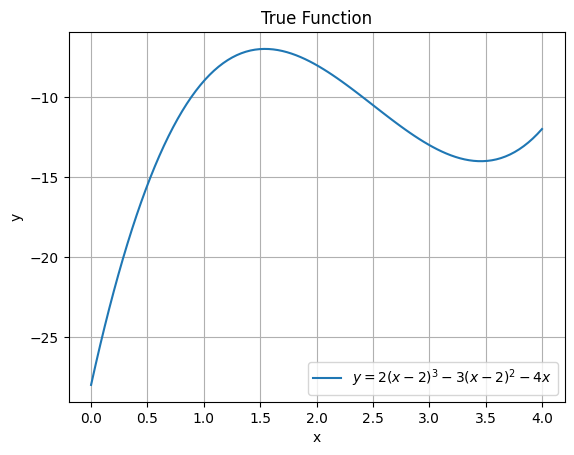

In [191]:
plot_true_function()

Now lets create 200 sample datasets for randomly sampled 100 x from {-100, -99, ..., +99, +100}

In [192]:
# Set a seed for reproducibility
samples = generate_data()

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2860.61it/s]


Visualizing one sample dataset with the true functional values ...

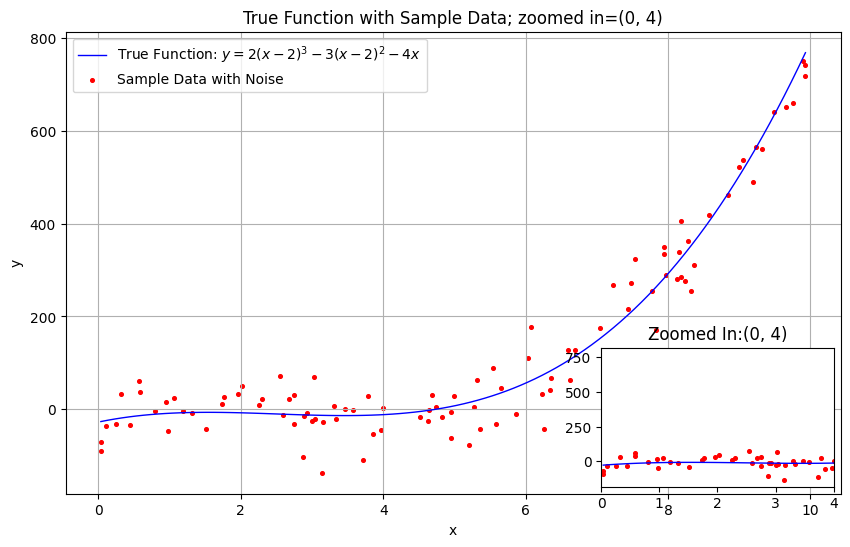

In [193]:
plot_true_function_with_data(samples[10], zoom_in=(0, 4))

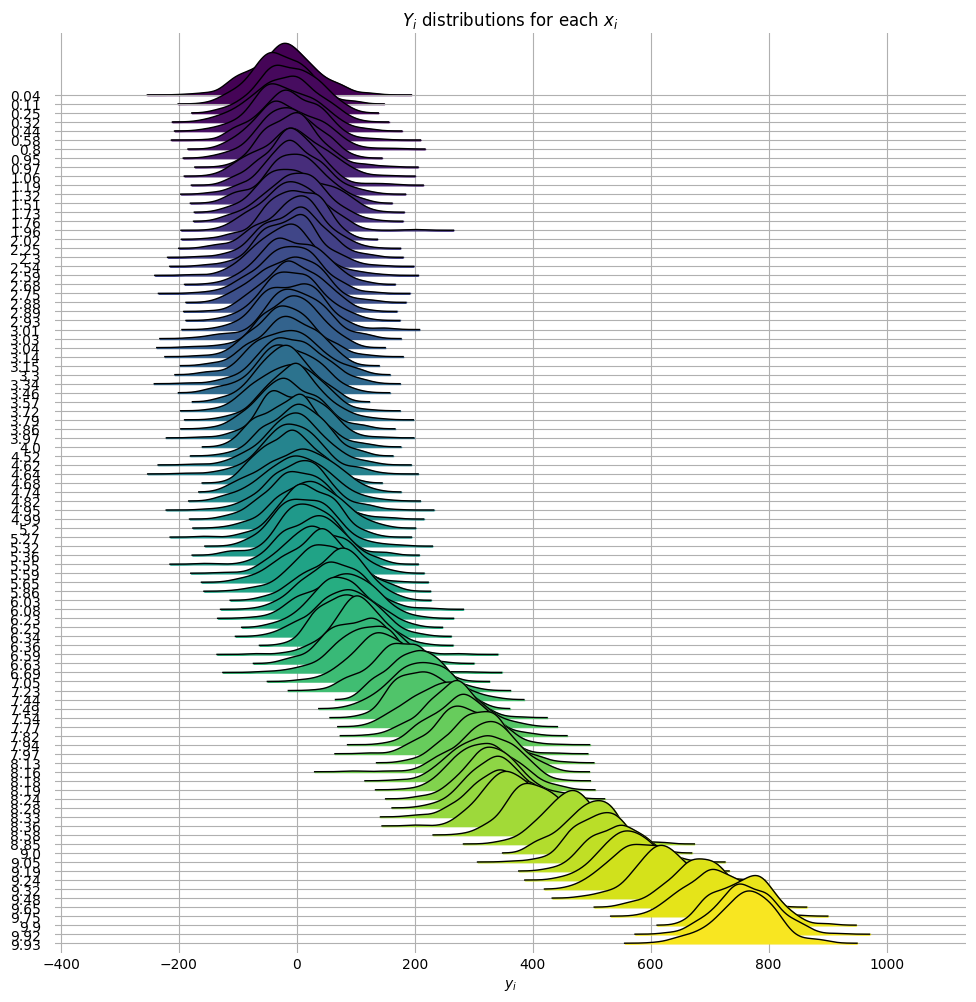

In [194]:
plot = plot_y_distributions_across_samples(np.array(samples))

# Modelling

## Linear Regression

In [195]:
samples[0][0:10,:]

array([[  6.252     , 155.30129314],
       [  4.684     ,  39.62417059],
       [  1.731     , 130.94624882],
       [  4.742     , -77.9725085 ],
       [  4.521     , -30.4079247 ],
       [  6.34      ,  34.47494838],
       [  0.576     ,  47.30598167],
       [  5.202     ,   3.06502697],
       [  6.363     ,  93.02262312],
       [  0.439     ,  15.01067064]])

In [196]:

models = []

for data in tqdm(samples, total=len(samples)):
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    models.append(model)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2010.83it/s]


In [197]:
predictions_across_samples = []

for data,model in tqdm(zip(samples,models), total=len(samples)):
    predictions = model.predict(data[:,0].reshape(-1,1))
    predictions_across_samples.append(predictions.reshape(-1,))

100%|██████████████████████████████████████| 200/200 [00:00<00:00, 15803.11it/s]


In [198]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
y_bars = np.sum(np.array(samples)[:,:,1], axis=0)/NUM_SAMPLES

bias_squared_for_each_xi = (y_bars - g_bars)**2
bias_squared = np.sum(bias_squared_for_each_xi)/NUM_DATAPOINTS

print("Bias of the hypothesis function : ", round(np.sqrt(bias_squared),2))

Bias of the hypothesis function :  118.49


In [199]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
distances = (np.array(predictions_across_samples) - g_bars)**2

var_for_each_xi = np.sum(distances, axis=0)/NUM_SAMPLES
variance = np.sum(var_for_each_xi)/NUM_DATAPOINTS

print("Variance of the hypothesis function : ", round(variance,2))

Variance of the hypothesis function :  46.31


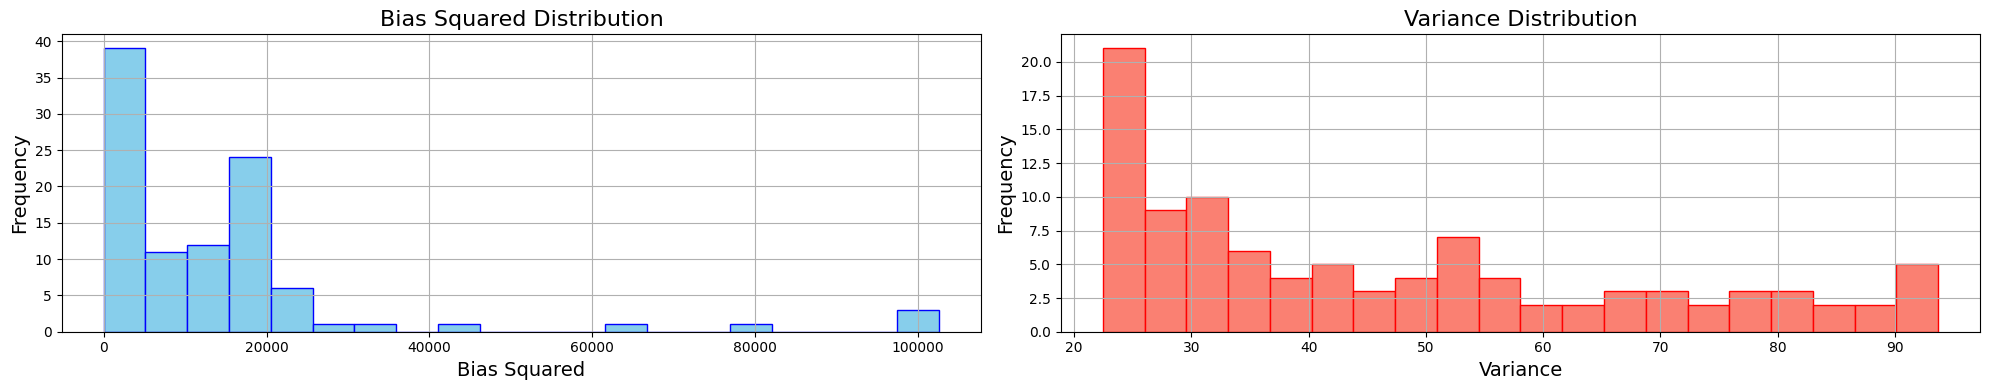

In [200]:
plt.figure(figsize=(20,4))

# Plot the first histogram
plt.subplot(121)
plt.hist(bias_squared_for_each_xi, bins=20, color='skyblue', edgecolor="blue")
plt.title('Bias Squared Distribution', fontsize=16)
plt.xlabel('Bias Squared', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Plot the second histogram
plt.subplot(122)
plt.hist(var_for_each_xi, bins=20, color='salmon', edgecolor="red")
plt.title('Variance Distribution', fontsize=16)
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.show()

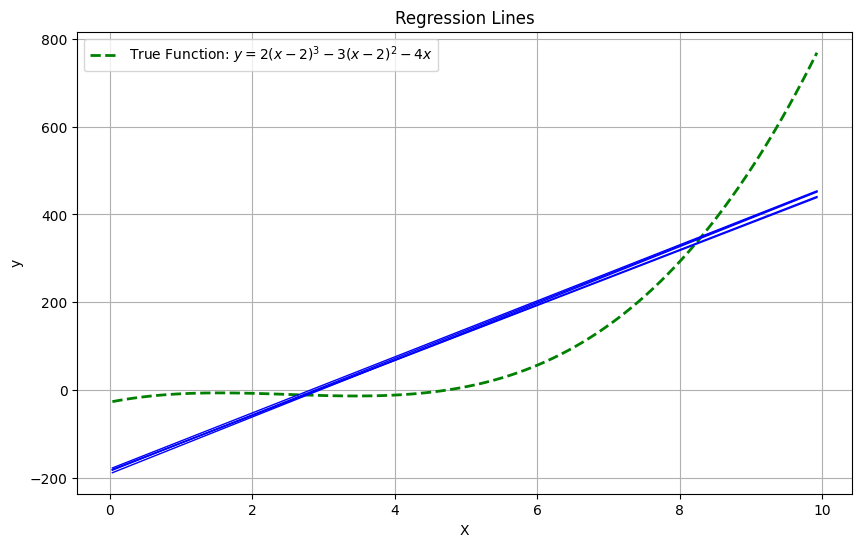

In [201]:
plot_regression_lines(samples, models)

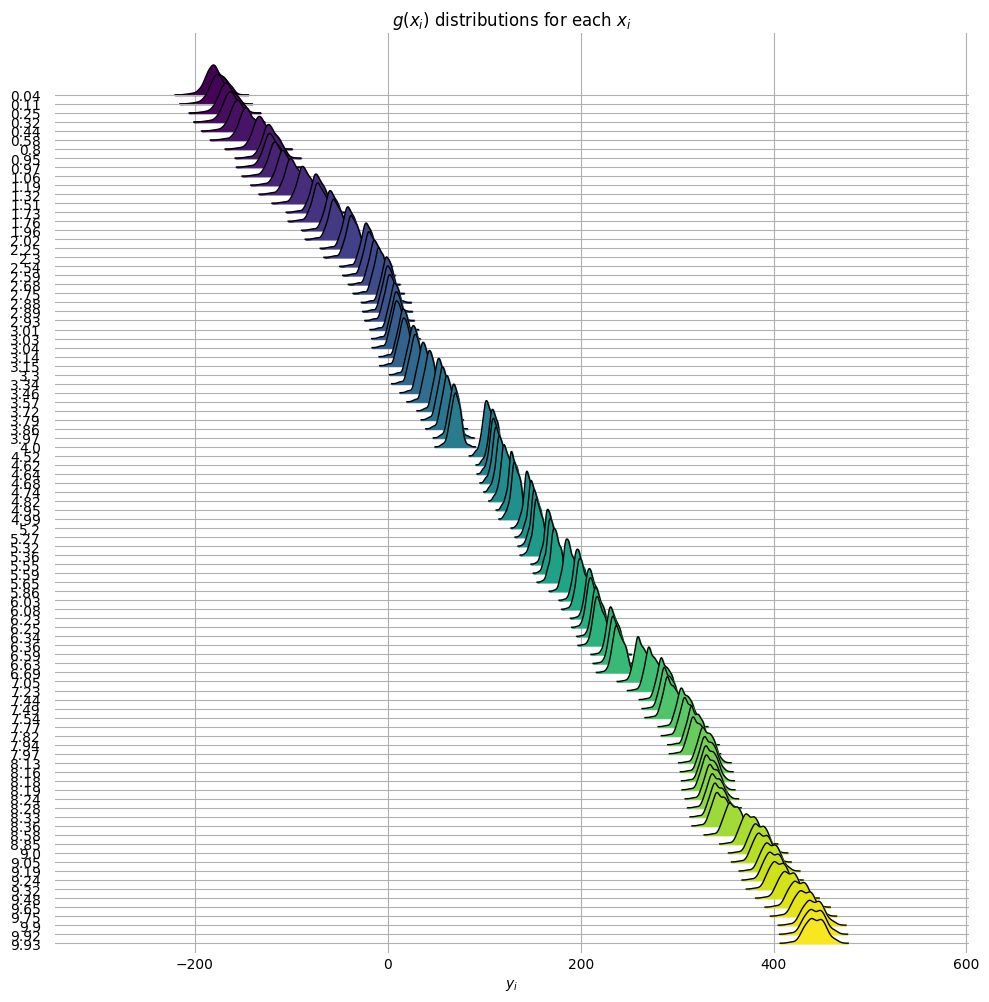

In [203]:
x_matrix = np.expand_dims(np.array(samples)[:,:,0], axis=2)
prediction_matrix = np.expand_dims(np.array(predictions_across_samples), axis=2)

result_matrix = np.concatenate((x_matrix, prediction_matrix), axis=2)

plot = plot_y_distributions_across_samples(result_matrix, title="$g(x_i)$ distributions for each $x_i$")

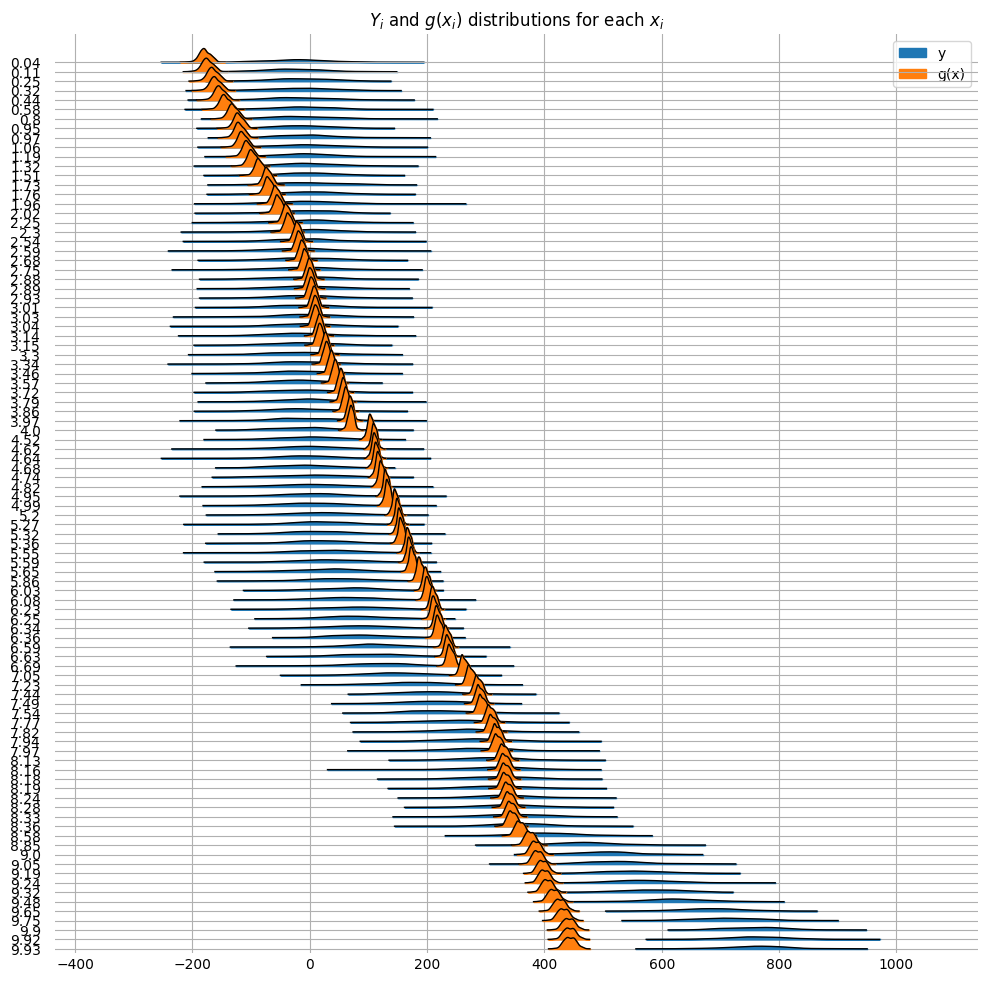

In [207]:
plot = plot_y_with_gx_distributions_across_samples(np.array(samples), result_matrix)

## Polynomial Regression

In [208]:
degree = 30

In [209]:

models = []

for data in tqdm(samples, total=len(samples)):
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)
    
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    models.append(model)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 977.67it/s]


In [210]:
predictions_across_samples = []

for data,model in tqdm(zip(samples,models), total=len(samples)):
    x = data[:,0].reshape(-1,1)
    x_poly = poly_features.transform(x)
    predictions = model.predict(x_poly)
    predictions_across_samples.append(predictions.reshape(-1,))

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3619.09it/s]


In [211]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
y_bars = np.sum(np.array(samples)[:,:,1], axis=0)/NUM_SAMPLES

bias_squared_for_each_xi = (y_bars - g_bars)**2
bias_squared = np.sum(bias_squared_for_each_xi)/NUM_DATAPOINTS

print("Bias of the hypothesis function : ", round(np.sqrt(bias_squared),2))

Bias of the hypothesis function :  7.23


In [212]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
distances = (np.array(predictions_across_samples) - g_bars)**2

var_for_each_xi = np.sum(distances, axis=0)/NUM_SAMPLES
variance = np.sum(var_for_each_xi)/NUM_DATAPOINTS

print("Variance of the hypothesis function : ", round(variance,2))

Variance of the hypothesis function :  218.65


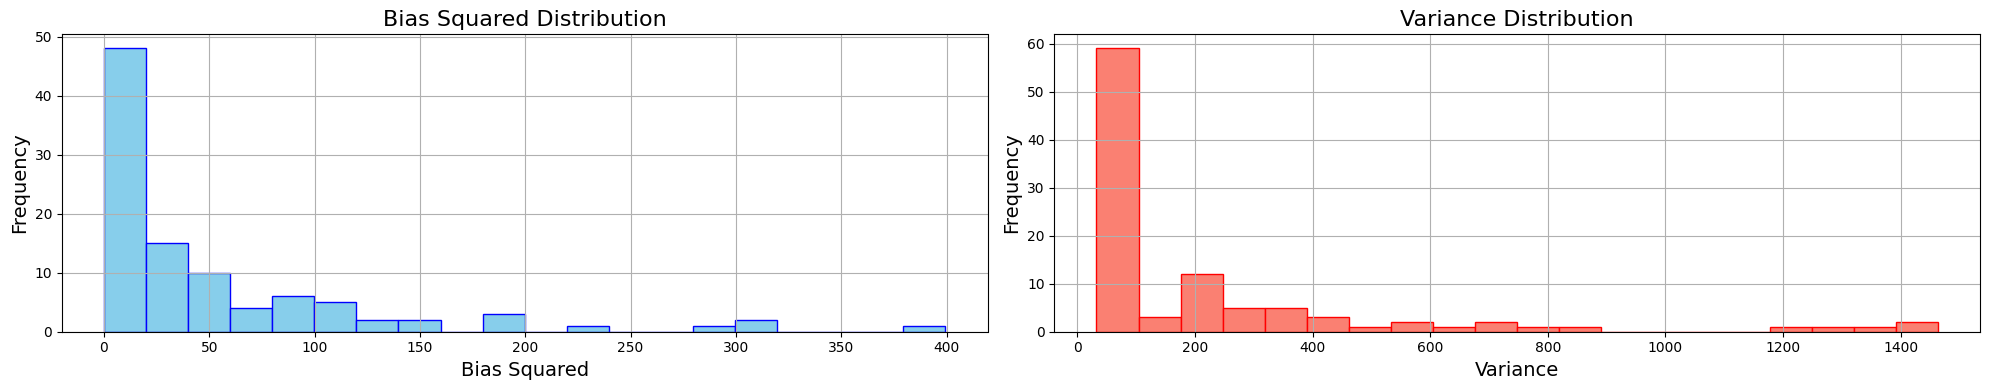

In [213]:
plt.figure(figsize=(20,4))

# Plot the first histogram
plt.subplot(121)
plt.hist(bias_squared_for_each_xi, bins=20, color='skyblue', edgecolor="blue")
plt.title('Bias Squared Distribution', fontsize=16)
plt.xlabel('Bias Squared', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Plot the second histogram
plt.subplot(122)
plt.hist(var_for_each_xi, bins=20, color='salmon', edgecolor="red")
plt.title('Variance Distribution', fontsize=16)
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.show()

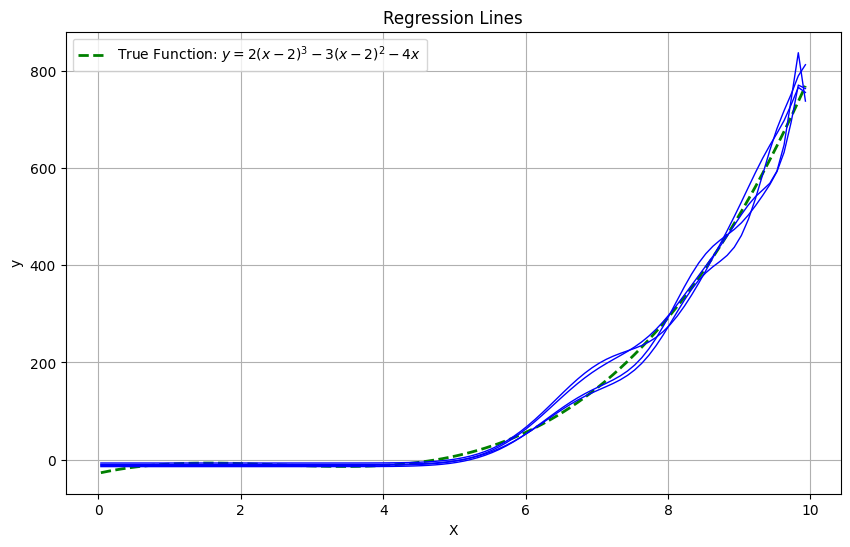

In [214]:
plot_regression_lines(samples, models, featurizer=poly_features, limit=4)

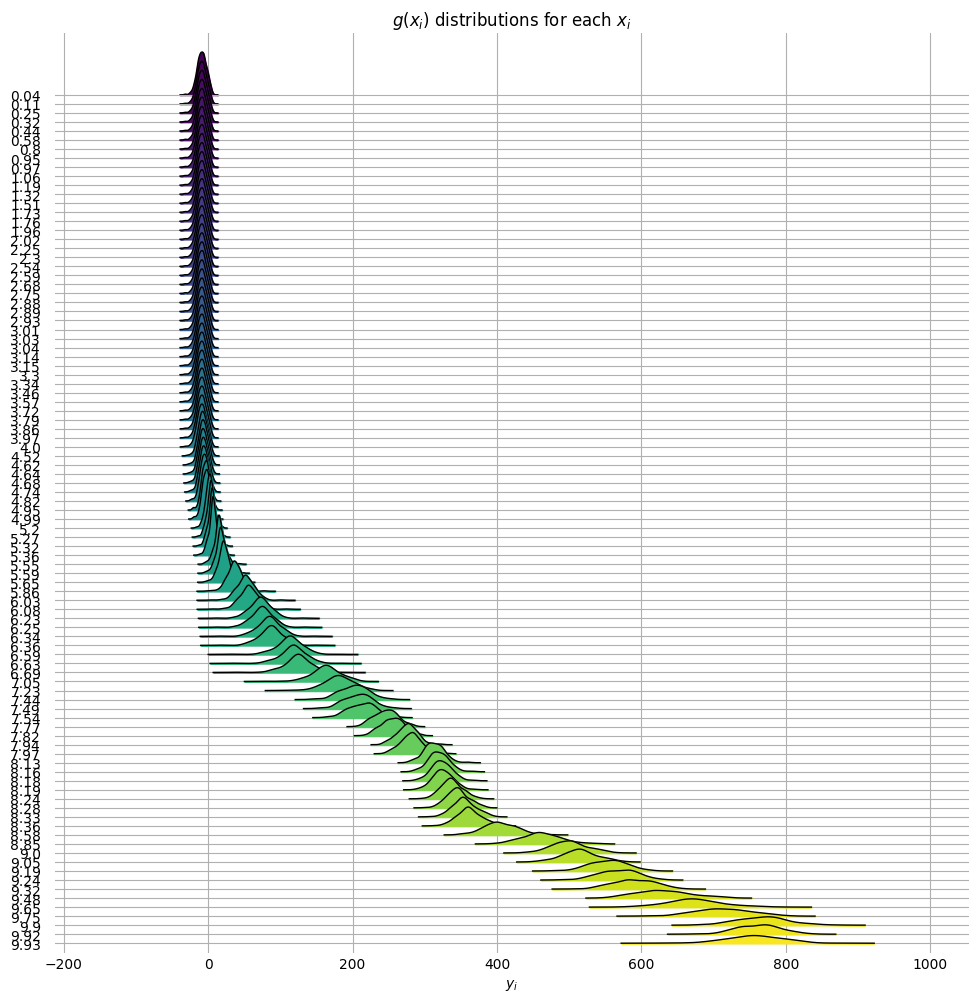

In [215]:
x_matrix = np.expand_dims(np.array(samples)[:,:,0], axis=2)
prediction_matrix = np.expand_dims(np.array(predictions_across_samples), axis=2)

result_matrix = np.concatenate((x_matrix, prediction_matrix), axis=2)

plot = plot_y_distributions_across_samples(result_matrix, title="$g(x_i)$ distributions for each $x_i$")

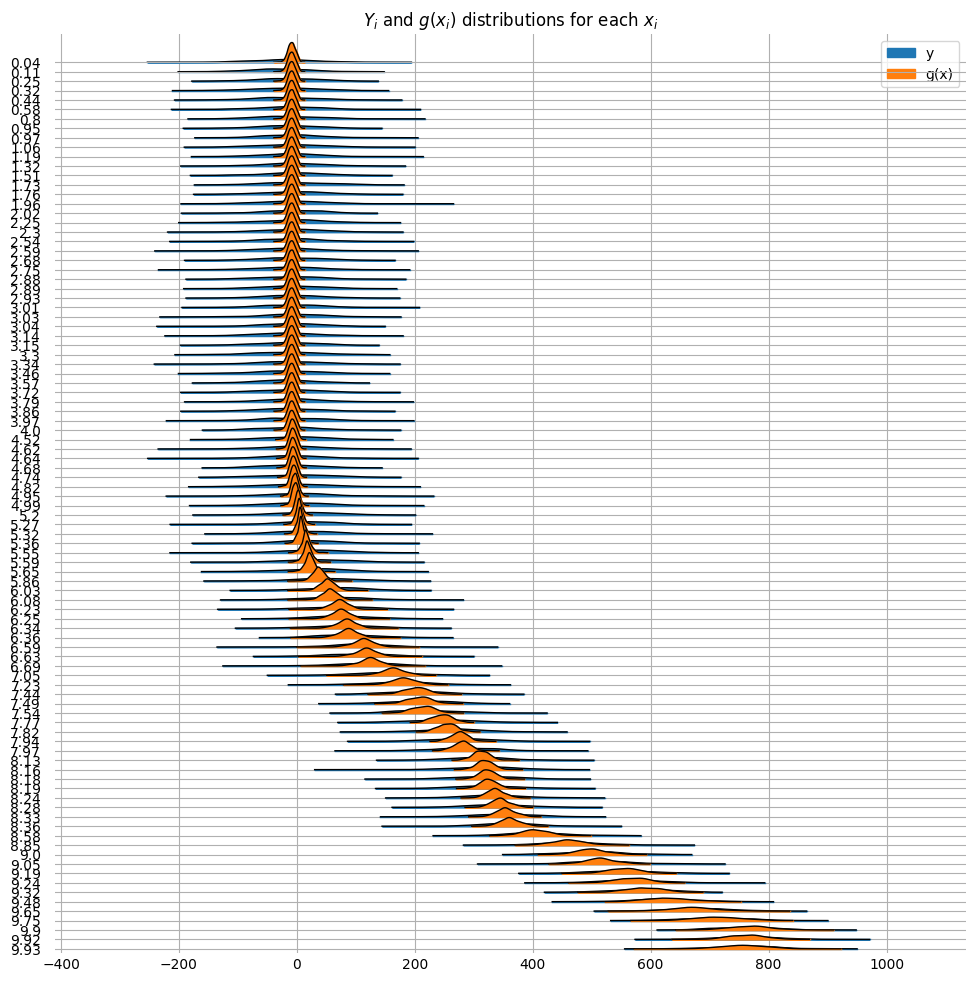

In [216]:
plot = plot_y_with_gx_distributions_across_samples(np.array(samples), result_matrix)